## Rotation of a Gaussian hill

This example is taken from **Section 13.2** in **Kuzmin and Turek (2004)**. The (non-dimensional) equation we are solving is a linear convection-diffusion equation in 2D, given as
$$
\partial_t u + \boldsymbol{b} \cdot \nabla u - \kappa \Delta u = 0, \qquad \forall\, \boldsymbol{x} \in \Omega = [-1,+1]^2, \quad t \in [t_0, t_f],
$$
where $t_0 = \pi/2$, $t_f = 5\pi/2$, with a diffusion constant of $\kappa = 0.001$ and a spatially-dependent wind velocity profile: $\boldsymbol{b} = (-y, x)^T$. 

The exact solution to this benchmark is a time-dependent Gaussian of the form
$$
u(x,y,t) = \frac{1}{4 \pi \kappa t} e^{-r^2/(4 \kappa t)},
$$
where $r^2 = (x - \widehat{x})^2 + (y - \widehat{y})^2$ and the center of the pulse is time-dependent, as such
$$
x(t) = x_0 \cos(t) - y_0 \sin(t), \qquad y(t) = -x_0 \sin(t) + y_0 \cos(t),
$$
with $(x_0, y_0) = (0, 0.5)$ denoting the initial position of the pulse at $t = t_0$.


[1] **Kuzmin, Dmitri, and Stefan Turek.**  
"High-resolution FEM-TVD schemes based on a fully multidimensional flux limiter."  
*Journal of Computational Physics*, 198.1 (2004): 131-158.

In [1]:
# Import preliminary modules.
from dream import *
from dream.scalar_transport import Initial, transportfields, ScalarTransportSolver, FarField
import ngsolve as ngs 

from netgen.occ import OCCGeometry, WorkPlane
from netgen.meshing import IdentificationType
from ngsolve.meshes import MakeStructured2DMesh

In [2]:
# Define the grid.

def CreateSimpleGrid(ne, lx, ly):

    # Select a common element size.
    h0 = min( lx, ly )/float(ne)

    # Generate a simple rectangular geometry.
    domain = WorkPlane().RectangleC(lx, ly).Face()

    # Assign the name of the internal solution in the domain.
    domain.name = 'internal'

    # For convenience, extract and name each of the edges consistently.
    bottom = domain.edges[0]; bottom.name = 'bottom'
    right  = domain.edges[1]; right.name  = 'right'
    top    = domain.edges[2]; top.name    = 'top'
    left   = domain.edges[3]; left.name   = 'left'

    # Initialize a rectangular 2D geometry.
    geo = OCCGeometry(domain, dim=2)

    # Discretize the domain.
    mesh = ngs.Mesh(geo.GenerateMesh(maxh=h0, quad_dominated=True))

    # Return our fancy grid.
    return mesh


In [3]:
# Generate the grid.

# Number of elements per dimension.
nElem1D = 20

# Dimension of the rectangular domain.
xLength = 2.0 
yLength = 2.0 

# Generate a simple grid.
mesh = CreateSimpleGrid(nElem1D, xLength, yLength)

# Message output detail from netgen.
ngs.ngsglobals.msg_level = 0 
ngs.SetNumThreads(4)
#Draw(mesh)

In [4]:
# Define analytic solution.
def get_analytic_solution(t, k): 
   
    # Initial pulse location.
    x0 = 0.0 
    y0 = 0.5 
   
    # Pulse center trajectory.
    xc =  x0*ngs.cos(t) - y0*ngs.sin(t)
    yc = -x0*ngs.sin(t) + y0*ngs.cos(t)
    
    # Radial distance (time-dependent).
    r2 = (ngs.x-xc)**2 + (ngs.y-yc)**2
    # Variance of this pulse.
    s2 = get_variance_pulse(t, k)

    # Return the analytic solution.
    return ( 1.0/(s2*ngs.pi) ) * ngs.exp( -r2/(4.0*k*t) )

def get_variance_pulse(t, k): 
    return 4.0*k*t
    


In [5]:
# Solver configuration: Scalar transport equation.
cfg = ScalarTransportSolver(mesh)

cfg.convection_velocity = (-ngs.y, ngs.x)
cfg.diffusion_coefficient = 1.0e-03
cfg.is_inviscid = False

cfg.riemann_solver = "lax_friedrich"
cfg.fem = "dg" # NOTE, by default, DG is used.
cfg.fem.order = 0
cfg.fem.interior_penalty_coefficient = 2.0


cfg.time = "transient"
cfg.fem.scheme = "implicit_euler"
cfg.time.timer.interval = (ngs.pi/2, 5*ngs.pi/2)
cfg.time.timer.step = 0.01

cfg.linear_solver = "pardiso"
cfg.optimizations.static_condensation = False  # NOTE, by default, condensation is turned off.
cfg.optimizations.compile.realcompile = False

U0 = transportfields()
U0.phi = get_analytic_solution(cfg.time.timer.interval[0], cfg.diffusion_coefficient)

Ubc = transportfields()
Ubc.phi = 0.0

cfg.bcs['left|top|bottom|right'] = FarField(fields=Ubc)
cfg.dcs['internal'] = Initial(fields=U0)

In [6]:
# Decorator for the actual simulation.
import numpy as np

# Extract time configuration.
t0, tf = cfg.time.timer.interval
dt = cfg.time.timer.step.Get()
nt = int(round((tf - t0) / dt))

# Define a decorator for the Gaussian hill routine.
def gaussian_hill_routine(label):
    def decorator(func):
        def wrapper(*args, draw_solution=False, **kwargs):

            # By default, assume this is a DG formulation.
            cfg.optimizations.static_condensation = False
            
            # Insert options here.
            func(*args, **kwargs)
            cfg.fem.order = 4
            cfg.fem.interior_penalty_coefficient = 2.0

            # In case an HDG formulation is specified, use static condensation.
            if cfg.fem.name == "hdg":
               cfg.optimizations.static_condensation = True
            
            # Allocate the necessary data.
            cfg.initialize()

            # Get a reference to the numerical solution and the analytic solution.
            uh = cfg.fem.get_fields("phi").phi
            ue = get_analytic_solution(cfg.time.timer.t, cfg.diffusion_coefficient)

            if draw_solution:
                # cfg.io.draw({"phi": Uh.phi})
                # cfg.io.draw({"Exact[phi]": Uex.phi},  min=0.0, max=10.0)
                cfg.io.draw({"Diff[phi]": (ue - uh)}, min=-0.01, max=0.01)
    
            # Integration order (for post-processing).
            qorder = 10
    
            # Data for book-keeping information.
            data = np.zeros((nt, 3), dtype=float)
    
            # Time integration loop  (actual simulation).
            for i, t in enumerate(cfg.time.start_solution_routine(True)):
                
                # Get the variance, based on the analytic solution.
                s2e = get_variance_pulse(cfg.time.timer.t.Get(), cfg.diffusion_coefficient.Get())
            
                # Compute centroid
                xh = ngs.Integrate(ngs.x * uh, mesh, order=qorder)
                yh = ngs.Integrate(ngs.y * uh, mesh, order=qorder)
            
                # Compute variance.
                r2h = (ngs.x - xh)**2 + (ngs.y - yh)**2
                s2h = ngs.Integrate(r2h * uh, mesh, order=(qorder+2) )

                # Compute the normalized variance error.
                var_dif = s2h/s2e - 1.0
                
                # Compute the L2-norm of the error.
                err = np.sqrt( ngs.Integrate( (ue-uh)**2, mesh, order=qorder) )
                
                # Store data: time and error metrics.
                data[i] = [cfg.time.timer.t.Get(), var_dif, err]
            return data
        wrapper.label = label 
        return wrapper
    return decorator

In [7]:
# Specialized routines.

@gaussian_hill_routine("implicit_euler(hdg)")
def implicit_euler_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "implicit_euler"

@gaussian_hill_routine("implicit_euler(dg)")
def implicit_euler_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "implicit_euler"

@gaussian_hill_routine("bdf2(hdg)")
def bdf2_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "bdf2"
@gaussian_hill_routine("bdf2(dg)")
def bdf2_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "bdf2"

@gaussian_hill_routine("sdirk22(hdg)")
def sdirk22_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "sdirk22"
@gaussian_hill_routine("sdirk22(dg)")
def sdirk22_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "sdirk22"

@gaussian_hill_routine("sdirk33(hdg)")
def sdirk33_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "sdirk33"
@gaussian_hill_routine("sdirk33(dg)")
def sdirk33_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "sdirk33"

@gaussian_hill_routine("imex_rk_ars443(dg)")
def imex_rk_ars443_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "imex_rk_ars443"

@gaussian_hill_routine("ssprk3(dg)")
def ssprk3_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "ssprk3"

@gaussian_hill_routine("crk4(dg)")
def crk4_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "crk4"

@gaussian_hill_routine("explicit_euler(dg)")
def explicit_euler_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "explicit_euler"

In [8]:
# Figure style and properties.
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from fractions import Fraction


# Assign colors to base method names
method_colors = {
    "implicit_euler": "tab:red",
    "bdf2": "tab:blue",
    "sdirk22": "tab:green",
    "sdirk33": "tab:purple"
}

# Helper function that sets up a generic figure.
def setup_fig(xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_xlim(t0, tf)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    return fig,ax

# Helper for formatting ticks as multiples of pi.
def pi_formatter(x, pos):
    frac = Fraction(x / np.pi).limit_denominator(8)
    if frac.numerator == 0:
        return "$0$"
    elif frac.denominator == 1:
        return rf"${frac.numerator}\pi$"
    else:
        return rf"${frac.numerator}\pi/{frac.denominator}$"

# Helper function that specifies the plot style properties.
def get_plot_style(label, method_colors):
    if label.endswith("(hdg)"):
        base_name = label.replace("(hdg)", "").strip()
        linestyle = "-"
        marker = 'o'
    elif label.endswith("(dg)"):
        base_name = label.replace("(dg)", "").strip()
        linestyle = "--"
        marker = '^'
    else:
        base_name = label.strip()
        linestyle = ":" 
        marker = '.'

    color = method_colors.get(base_name, "black")

    return {
        "label": label,
        "linestyle": linestyle,
        "marker": marker,
        "markersize": 8,
        "markevery": 50,
        "color": color
    }


Running implicit_euler(hdg)...


WebGuiDocuWidget(value={'render_data': 'render_data_2.json', 'preview': 'preview_2.png'})

Running bdf2(hdg)...


WebGuiDocuWidget(value={'render_data': 'render_data_3.json', 'preview': 'preview_3.png'})

Running sdirk22(hdg)...


WebGuiDocuWidget(value={'render_data': 'render_data_4.json', 'preview': 'preview_4.png'})

Running sdirk33(hdg)...


WebGuiDocuWidget(value={'render_data': 'render_data_5.json', 'preview': 'preview_5.png'})

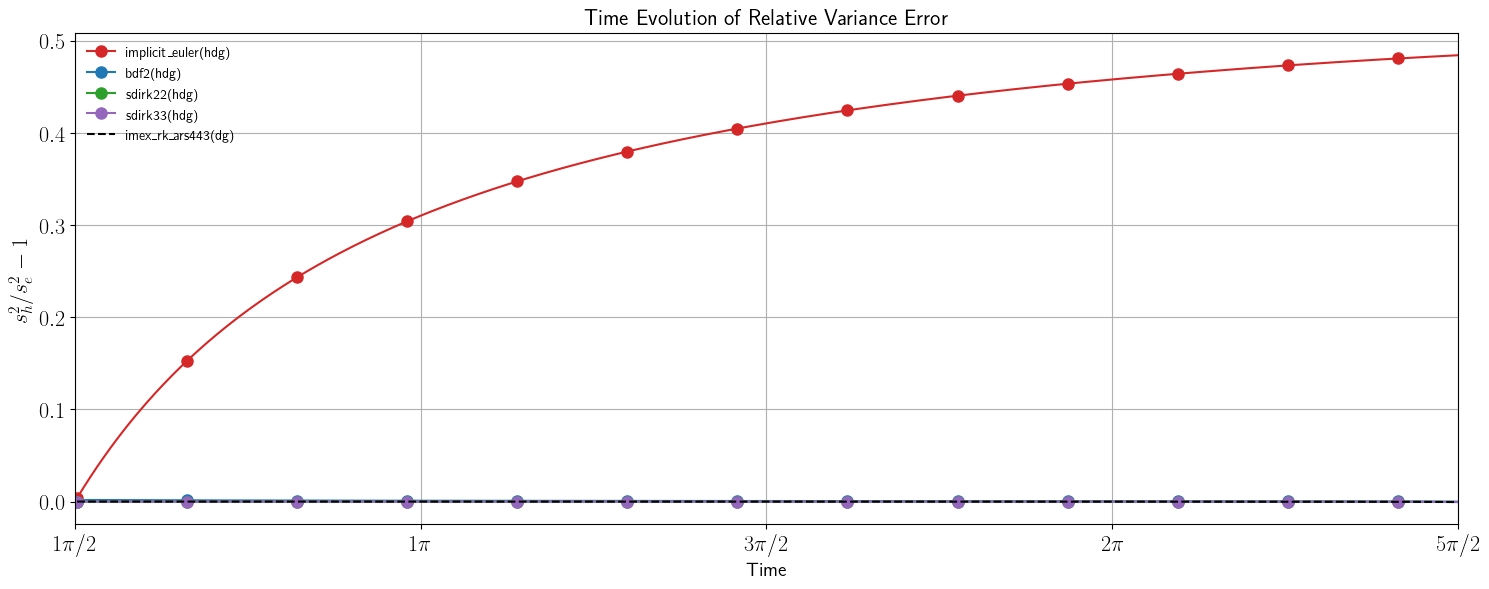

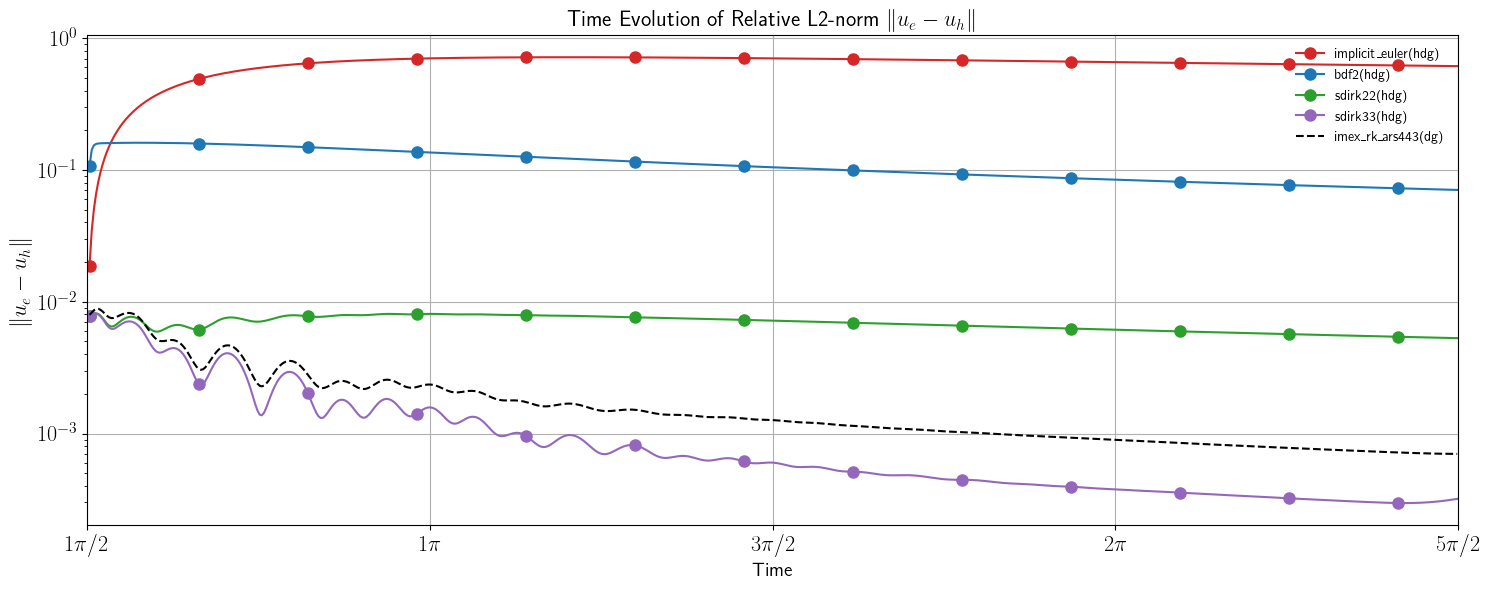

In [9]:
# Run simulation(s).
routines = [implicit_euler_hdg,
                      bdf2_hdg,
                   sdirk22_hdg,
                   sdirk33_hdg]
# Figure 1: Linear plot of the relative error in the variance.
fig1, ax1 = setup_fig("Time", r"$s^2_h / s^2_e - 1$", "Time Evolution of Relative Variance Error")

# Figure 2: logaraithmic plot of the relative error in the L2-norm.
fig2, ax2 = setup_fig("Time", r"$\| u_e - u_h \|$", r"Time Evolution of Relative L2-norm $\| u_e - u_h \|$")

# Run each simulation.
for routine in routines:
    print(f"Running {routine.label}...")
    data = routine(draw_solution=True)
    style = get_plot_style(routine.label, method_colors)

    ax1.plot(data[:, 0], data[:, 1], **style)
    ax2.semilogy(data[:, 0], data[:, 2], **style)

# Add IMEX-RK for DG only.
data = imex_rk_ars443_dg()
ax1.plot(data[:, 0], data[:, 1], label=imex_rk_ars443_dg.label, linestyle='--', color='k')
ax2.semilogy(data[:, 0], data[:, 2], label=imex_rk_ars443_dg.label, linestyle='--', color='k')

# Final touches.
ax1.legend(frameon=False)
ax2.legend(loc="upper right", frameon=False)
fig1.tight_layout()
fig2.tight_layout()
plt.show()